# 1.Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# 2.Load Dataset

In [2]:
dataset = pd.read_csv('capture20110810.binetflow.2format')
dataset = dataset[dataset['Label'].str.contains('Botnet')]
print('Rows:',dataset.shape[0], 'Columns:', dataset.shape[1])
dataset.sample(5)

Rows: 40961 Columns: 33


,SrcAddr,DstAddr,Proto,Sport,Dport,State,sTos,dTos,SrcWin,DstWin,...,SAppBytes,DAppBytes,Dur,TotPkts,TotBytes,TotAppByte,Rate,SrcRate,DstRate,Label
1596976,147.32.84.165,209.85.225.27,tcp,4854,25,REQ,0.0,NaN,64240.0,NaN,...,0,0,9.012702,3,186,0,0.221909,0.221909,0.0,flow=From-Botnet-V42-TCP-Attempt-SPAM
2635844,147.32.84.165,62.24.139.61,tcp,3844,25,REQ,0.0,NaN,64240.0,NaN,...,0,0,9.012841,3,186,0,0.221906,0.221906,0.0,flow=From-Botnet-V42-TCP-Attempt-SPAM
1735511,147.32.84.165,192.93.0.4,udp,2077,53,CON,0.0,0.0,NaN,NaN,...,25,73,0.030433,2,182,98,32.859070,0.000000,0.0,flow=From-Botnet-V42-UDP-DNS
1674393,147.32.84.165,194.85.61.20,udp,2077,53,CON,0.0,0.0,NaN,NaN,...,35,109,0.065272,2,228,144,15.320504,0.000000,0.0,flow=From-Botnet-V42-UDP-DNS
1469287,147.32.84.165,88.212.221.8,udp,2077,53,CON,0.0,0.0,NaN,NaN,...,35,148,0.062068,2,267,183,16.111362,0.000000,0.0,flow=From-Botnet-V42-UDP-DNS


In [3]:
dataset['Label'].nunique()

68

# 3.Data Processing

# 3.1.Missing Data Processing

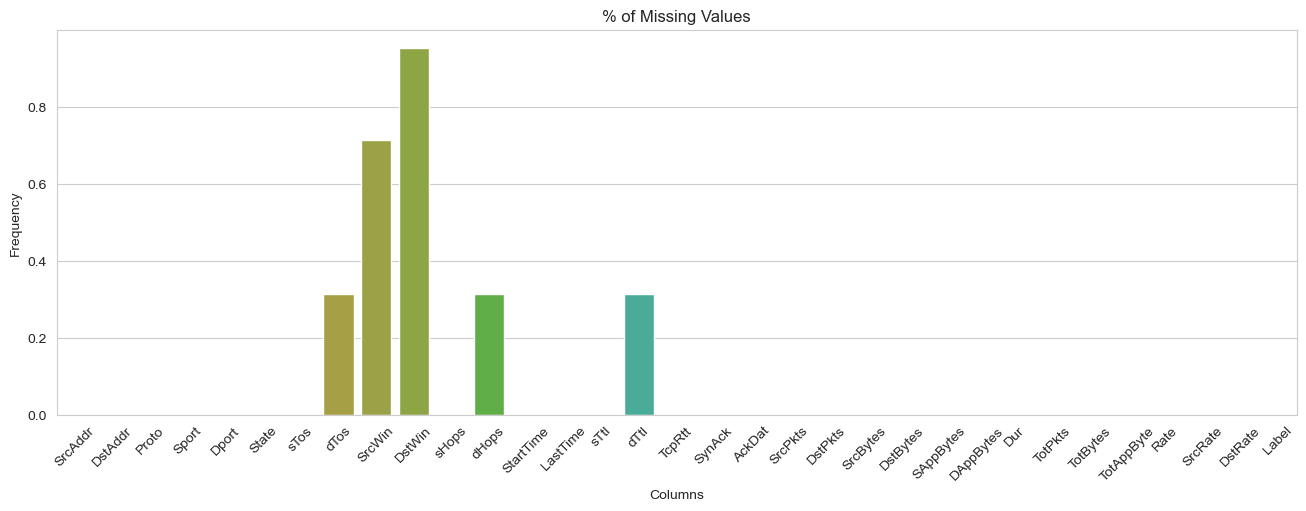

In [4]:
plt.figure(figsize=(16,5))
sns.set_style('whitegrid')
plt.title('% of Missing Values')
sns.barplot(x=dataset.isnull().mean().index, y=dataset.isnull().mean().values)
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

In [5]:
dataset = dataset.loc[:, dataset.isnull().mean() < 0.3]

# 3.2.Features Processing

In [6]:
dataset = dataset.astype({"Proto":'category',"Sport":'category',"Dport":'category',"State":'category','StartTime':'datetime64[s]','LastTime':'datetime64[s]'})
dataset['duration'] = abs(dataset['LastTime'].dt.second - dataset['StartTime'].dt.second)
dataset.drop(columns=['SrcAddr','DstAddr','LastTime','StartTime'],inplace=True)

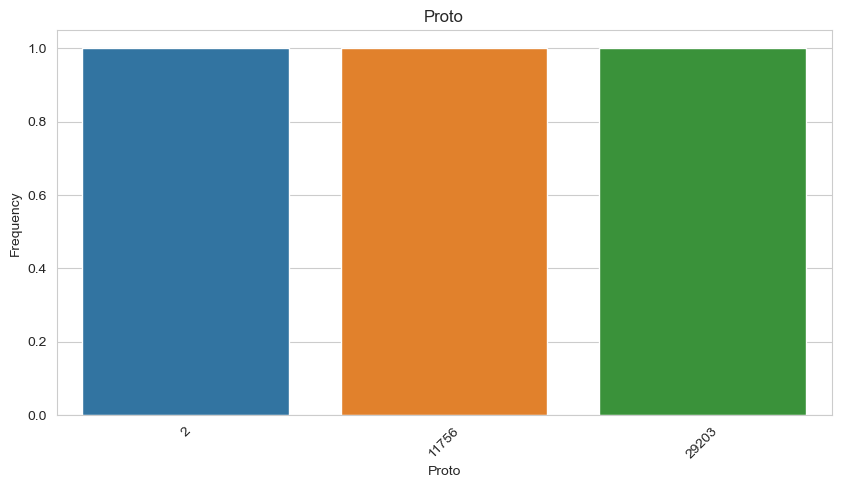

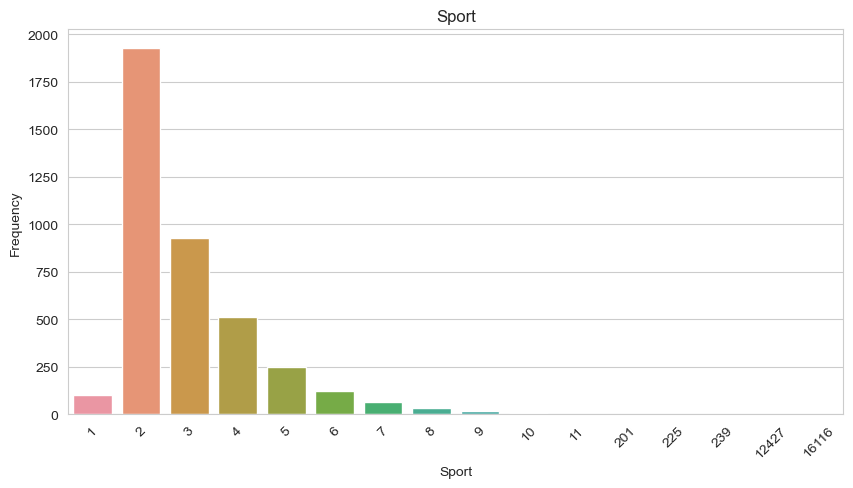

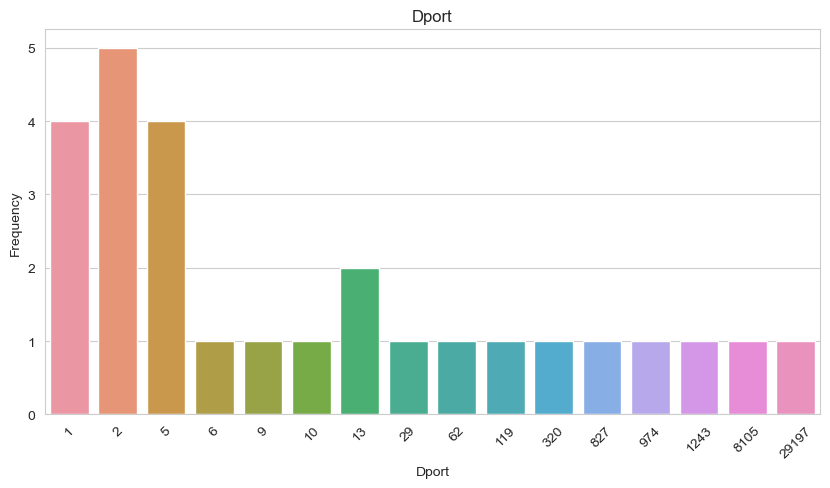

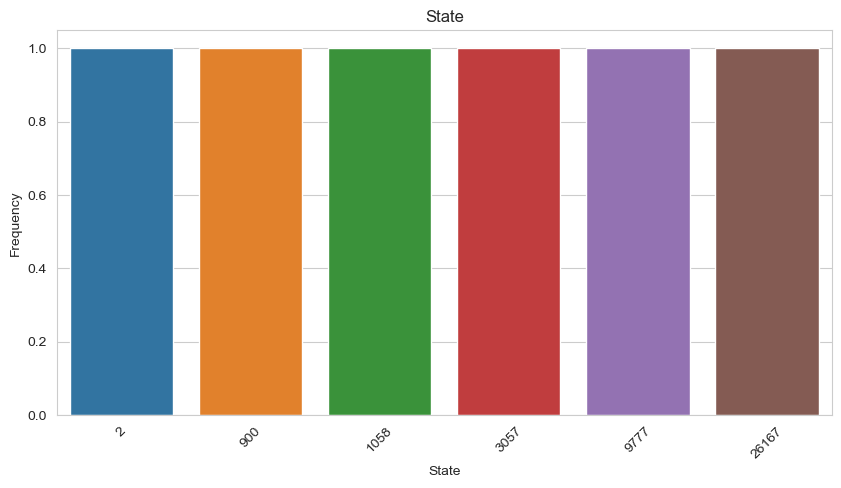

In [7]:
def barchart(columns):
    plt.figure(figsize=(10,5))
    plt.title(f'{columns}')
    sns.countplot(x=dataset[f'{columns}'].value_counts().values)
    plt.xlabel(f'{columns}')
    plt.xticks(rotation=45)
    plt.ylabel('Frequency')
    plt.show()
    
categorical_columns = dataset.select_dtypes(exclude=['int64', 'float64']).columns.values      
for column in categorical_columns:
    if column != 'Label':
        barchart(column)

# 4.Data Split

In [8]:
dataset = pd.get_dummies(dataset,columns=categorical_columns[:-1],drop_first=True)
X = dataset.loc[:, dataset.columns != 'Label']
y = dataset.loc[:, dataset.columns == 'Label']

In [9]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2,random_state=45)

# 5.Model Training

# 5.1.Decision Tree

# 5.1.1.parameter tuning

To begin, we should decide the parameters. Whether gini model or entropy model is the first thing we should decide.

In [10]:
DT = DecisionTreeClassifier(random_state = 66)
score = cross_val_score(DT,X,y,cv=10).mean()
print('Gini Score: %.4f'%score)
DT = DecisionTreeClassifier(criterion = 'entropy',random_state = 66)
score = cross_val_score(DT,X,y,cv=10).mean()
print('Entropy Score: %.4f'%score)

Gini Score: 0.9940
Entropy Score: 0.9939


Gini model is better! Moreover, the max_depth should be decide.

Best parameter and highest score: [20.          0.99411636]


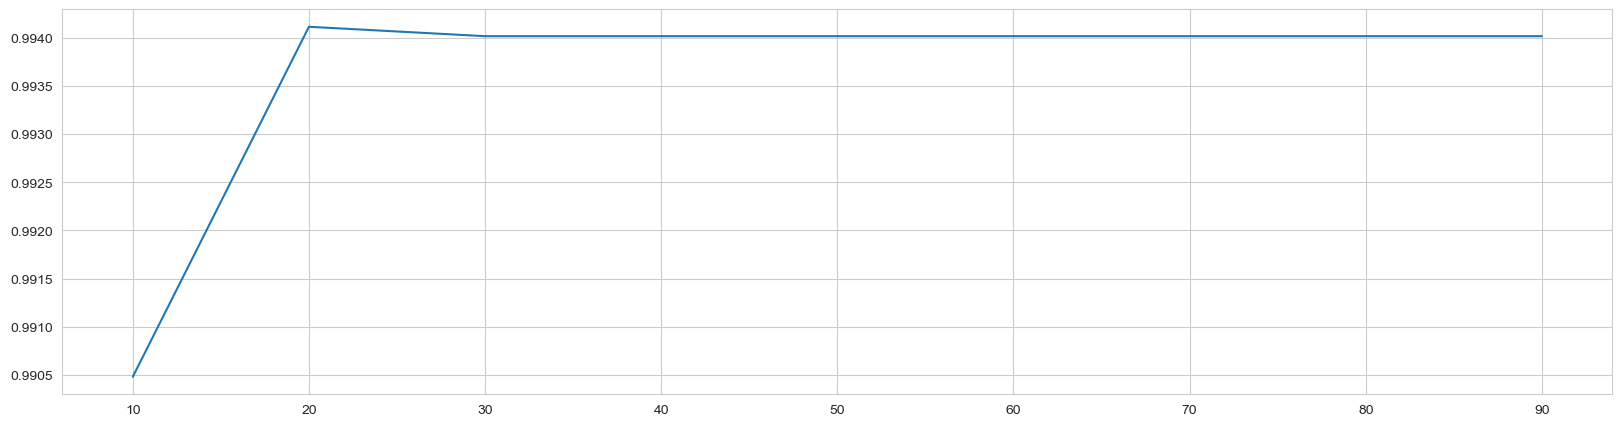

In [11]:
ScoreAll = []
for i in range(10,100,10):
    DT = DecisionTreeClassifier(max_depth = i,random_state = 66)
    score = cross_val_score(DT,X,y,cv=10).mean()
    ScoreAll.append([i,score])
ScoreAll = npScoreAll = []

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] ##Find the index to the highest score
print("Best parameter and highest score:",ScoreAll[max_score])  
# print(ScoreAll[,0])
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show().array(ScoreAll)

It can be easily observed that the best max_depth is about 20. However, it can not be ignored that in order to have a wide searching range, the step is 10, which may not be precise enough. Therefore, a smaller range searching should be conducted.

Best parameter and highest score: [20.          0.99411636]


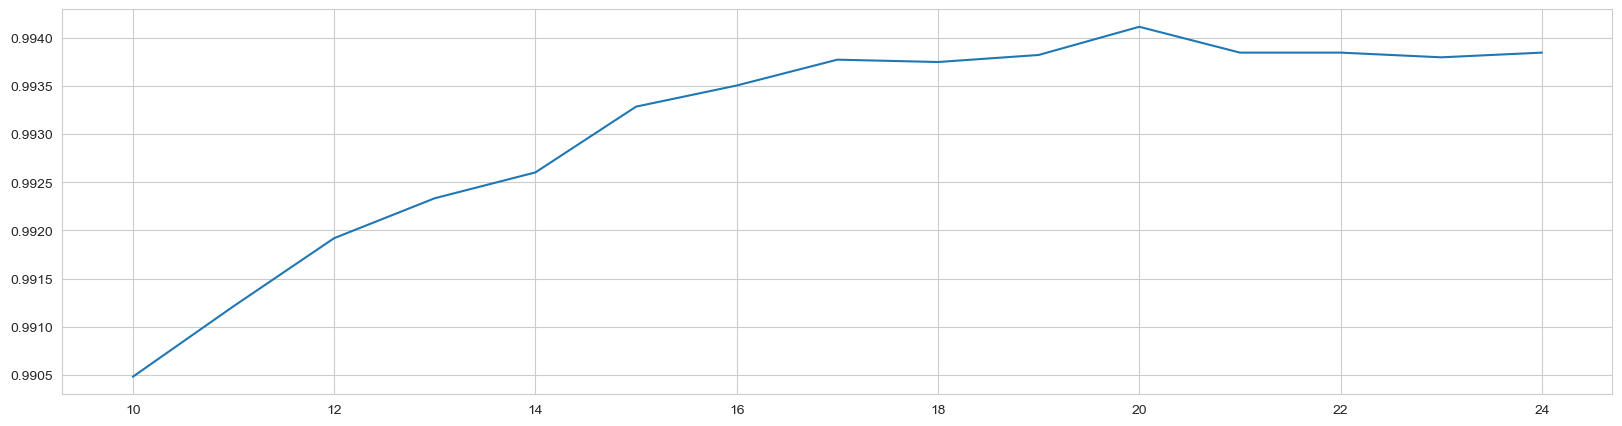

In [12]:
ScoreAll = []
for i in range(10,25):
    DT = DecisionTreeClassifier(max_depth = i,random_state = 66)
    score = cross_val_score(DT,X,y,cv=10).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] 
print("Best parameter and highest score:",ScoreAll[max_score])  
# print(ScoreAll[,0])
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

Now it has been proved that 20 is the max_depth. Our next task is to utilize this parameter to get the min_samples_split.

Best parameter and highest score: [2.         0.99411636]


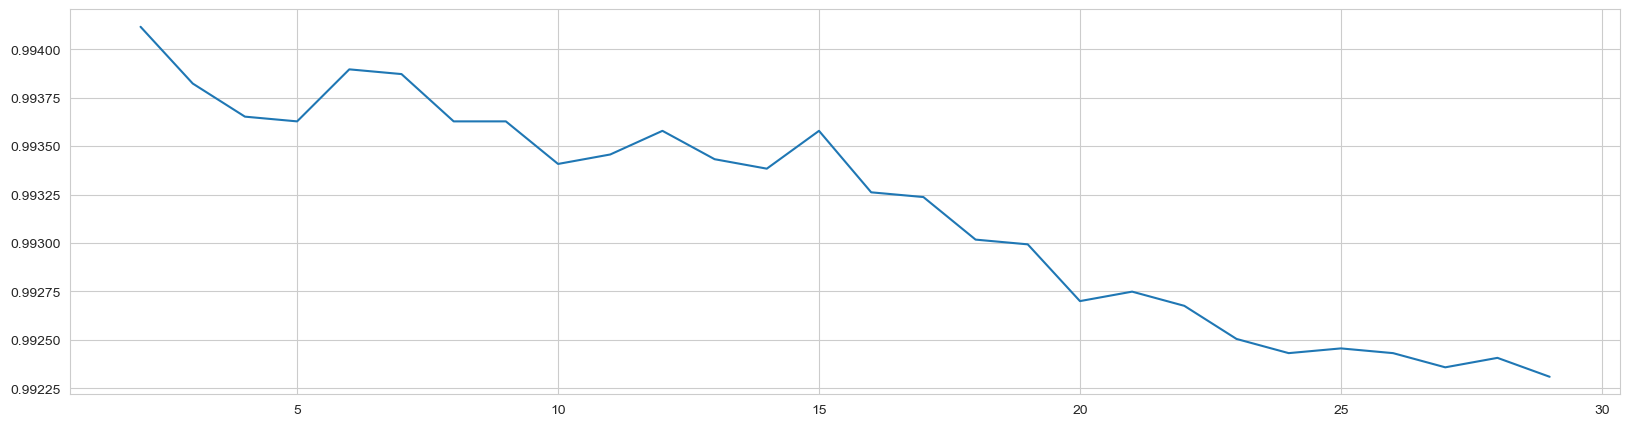

In [13]:
ScoreAll = []
for i in range(2,30):
    DT = DecisionTreeClassifier(max_depth = 20,min_samples_split = i,random_state = 66)
    score = cross_val_score(DT,X,y,cv=10).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] 
print("Best parameter and highest score:",ScoreAll[max_score])  
# print(ScoreAll[,0])
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

Currently the best max_depth and min_samples_split have already been decided, the only parameter left is min_samples_leaf.

Best parameter and highest score: [1.         0.99411636]


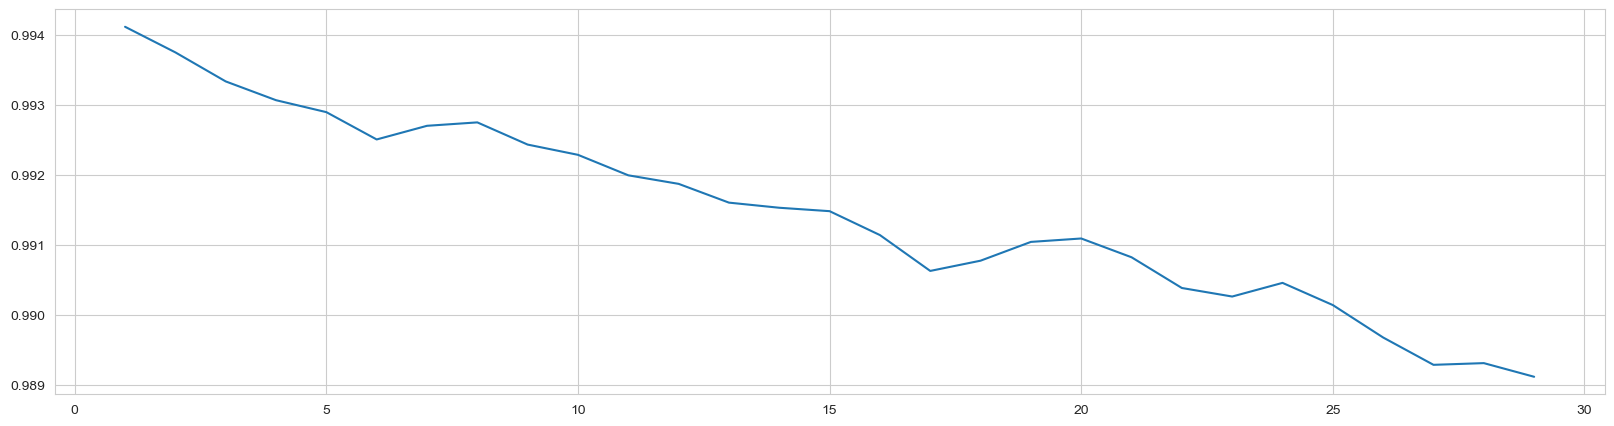

In [14]:
ScoreAll = []
for i in range(1,30):
    DT = DecisionTreeClassifier(min_samples_leaf = i,min_samples_split = 2,max_depth = 20,random_state = 66)
    score = cross_val_score(DT, X, y, cv=10).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] 
print("Best parameter and highest score:",ScoreAll[max_score])  
# print(ScoreAll[,0])
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

The last work is joint debugging.

In [16]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth':np.arange(19, 21),
    'min_samples_leaf':np.arange(1, 6),
    'min_samples_split':np.arange(1, 4)}

DT = DecisionTreeClassifier(random_state=66)
GS = GridSearchCV(DT,param_grid,cv=10)
GS.fit(X,y)
print(GS.best_params_)
print(GS.best_score_)

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.994116359912741


According the result, the best parameters are max_depth 20, min_samples_leaf 1, min_samples_split 2. Our model should be trained with these parameters.

# 5.1.2.Training

In [19]:
DT = DecisionTreeClassifier(min_samples_leaf = 1,min_samples_split = 2,max_depth = 20,random_state = 66)
DT.fit(Xtrain,ytrain)
prediction = DT.predict(Xtest)
print('Decision Accuracy Score:',round(accuracy_score(ytest,prediction)*100),'%')

Decision Accuracy Score: 99 %


# 5.1.3.Result

In [20]:
from sklearn import tree
print(tree.export_graphviz(DT))

digraph Tree {
node [shape=box, fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="X[11] <= 24.5\ngini = 0.547\nsamples = 32768\nvalue = [1, 1551, 6480, 26, 181, 46, 9, 9, 8, 35, 2, 5\n29, 12, 3, 22, 14, 28, 25, 23, 6, 2, 10, 16\n12, 3, 1, 20, 11, 7, 2, 19, 5, 3, 6, 1, 3, 2\n4, 3, 2, 21, 3, 4, 5, 1, 11, 282, 2, 6, 16\n1, 2, 5, 2, 1, 2, 48, 10, 8, 1, 255, 72, 42\n2440, 20877, 4]"] ;
1 [label="X[3999] <= 0.5\ngini = 0.556\nsamples = 10646\nvalue = [1, 1549, 6480, 5, 17, 0, 8, 4, 0, 24, 0, 0, 0\n0, 0, 0, 4, 1, 0, 2, 0, 0, 3, 2, 0, 0, 0\n0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0\n7, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0\n0, 0, 0, 0, 0, 1, 94, 2, 0, 2440, 1, 0]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="X[4023] <= 0.5\ngini = 0.518\nsamples = 4166\nvalue = [1, 1549, 0, 5, 17, 0, 8, 4, 0, 24, 0, 0, 0\n0, 0, 0, 4, 1, 0, 2, 0, 0, 3, 2, 0, 0, 0\n0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0\n7, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0\n0, 0, 0, 0, 0, 1, 94, 

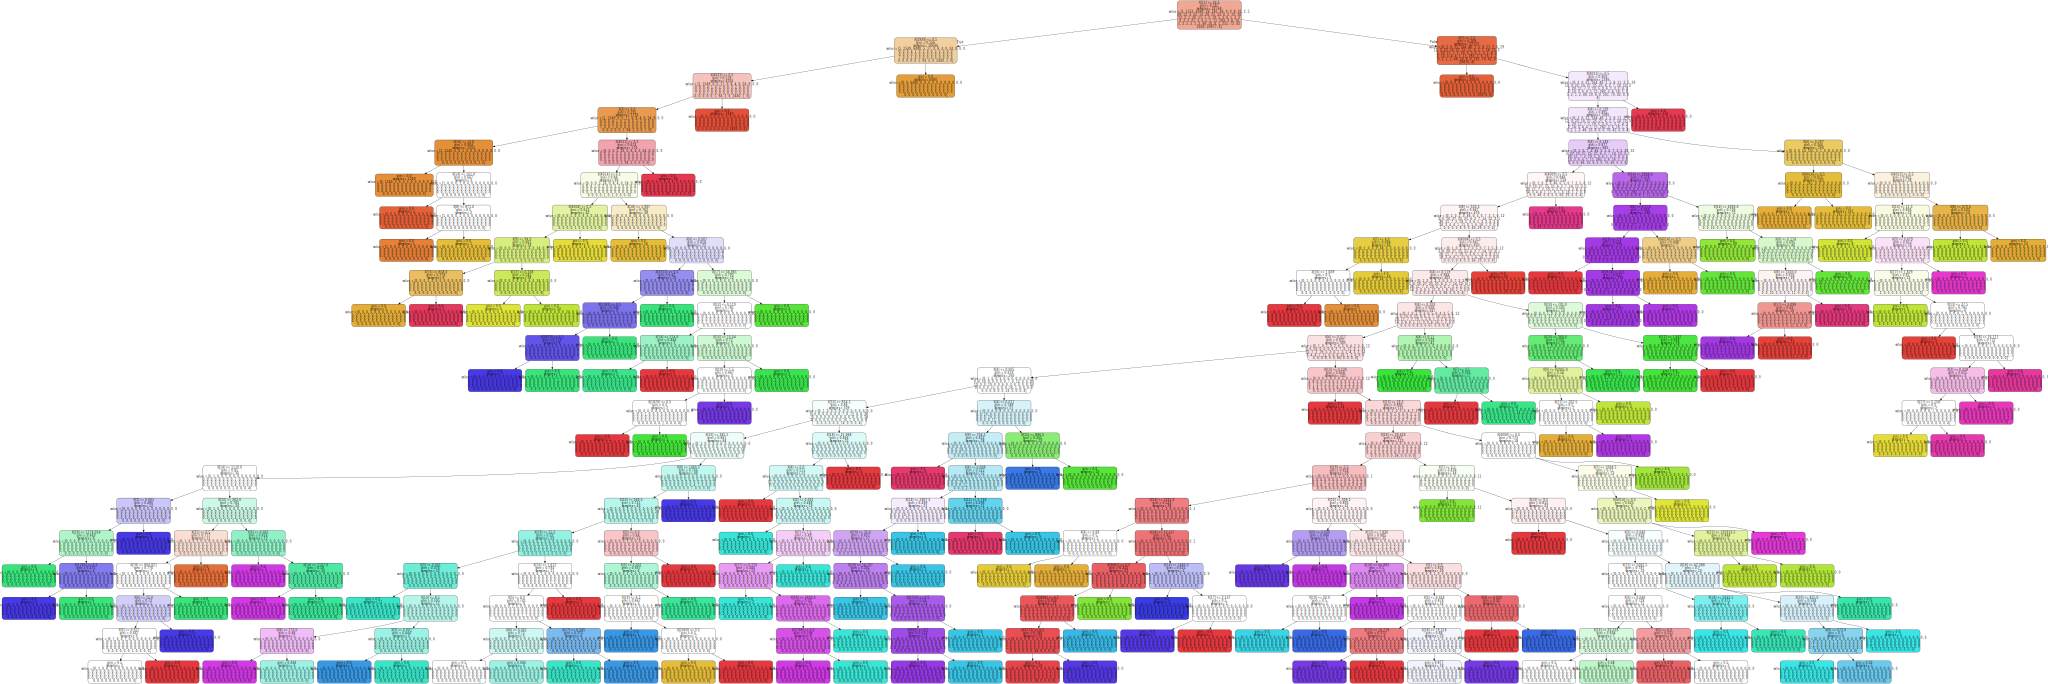

In [21]:
import graphviz
dot_data = tree.export_graphviz(DT
                               ,filled = True
                               ,rounded = True
                               )
graph = graphviz.Source(dot_data)
graph

# 5.2.Random Forest

# 5.2.1.Parameter Tuning 

Highest Score：0.9943361103112796 The number of subtrees：81


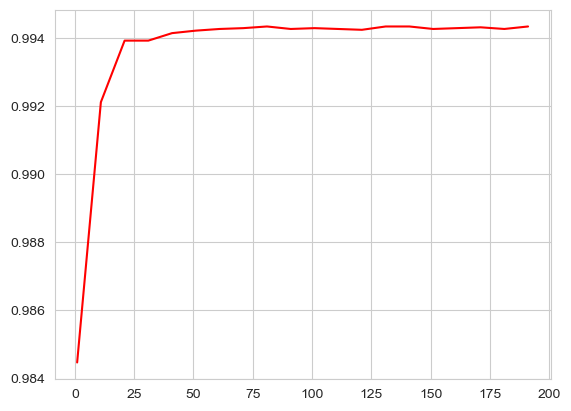

In [22]:
score_lt = []

for i in range(0,200,10):
    rfc = RandomForestClassifier(n_estimators=i+1
                                ,random_state=90)
    score = cross_val_score(rfc, X, y, cv=10).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('Highest Score：{}'.format(score_max),
      'The number of subtrees：{}'.format(score_lt.index(score_max)*10+1))

x = np.arange(1,201,10)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

Highest Score：0.9944337665612796 The number of subtrees：77


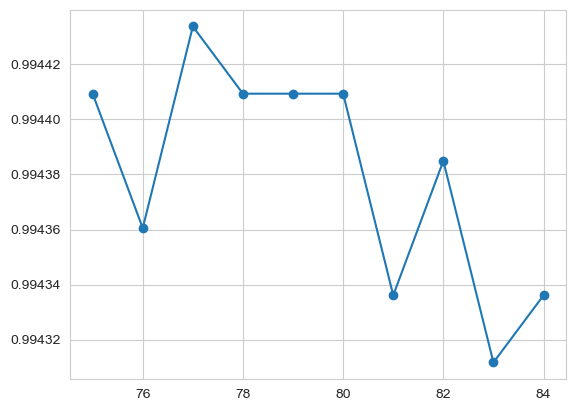

In [26]:
score_lt = []
for i in range(75,85):
    rfc = RandomForestClassifier(n_estimators=i
                                ,random_state=90)
    score = cross_val_score(rfc, X, y, cv=10).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('Highest Score：{}'.format(score_max),
      'The number of subtrees：{}'.format(score_lt.index(score_max)+75))

x = np.arange(75,85)
plt.subplot(111)
plt.plot(x, score_lt,'o-')
plt.show()

Highest Score：0.9944337725202892 The number of subtrees：71


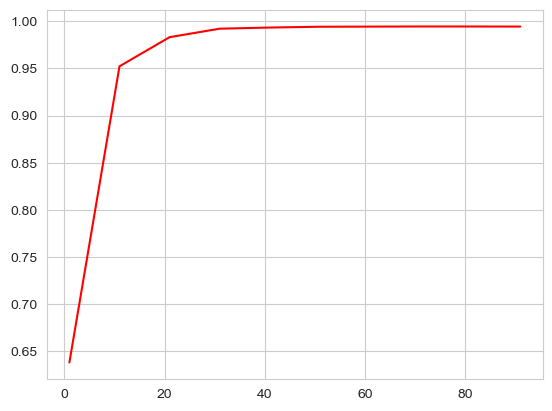

In [30]:
score_lt = []

for i in range(0,100,10):
    rfc = RandomForestClassifier(max_depth=i+1, n_estimators = 77, random_state=90)
    score = cross_val_score(rfc, X, y, cv=10).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('Highest Score：{}'.format(score_max),
      'The number of subtrees：{}'.format(score_lt.index(score_max)*10+1))

x = np.arange(1,101,10)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

Highest Score：0.9944337725202892 The number of subtrees：70


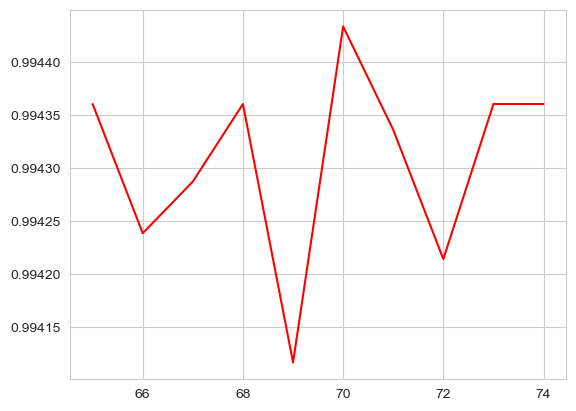

In [31]:
score_lt = []

for i in range(65, 75):
    rfc = RandomForestClassifier(max_depth=i+1, n_estimators = 77, random_state=90)
    score = cross_val_score(rfc, X, y, cv=10).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('Highest Score：{}'.format(score_max),
      'The number of subtrees：{}'.format(score_lt.index(score_max)+65))

x = np.arange(65, 75)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

Highest Score：0.9943117141258085 The number of subtrees：5


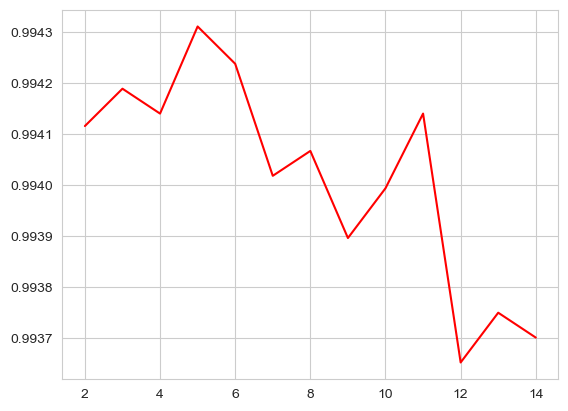

In [32]:
score_lt = []

for i in range(2, 15):
    rfc = RandomForestClassifier(min_samples_split = i, max_depth = 70, n_estimators = 77, random_state=90)
    score = cross_val_score(rfc, X, y, cv=10).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('Highest Score：{}'.format(score_max),
      'The number of subtrees：{}'.format(score_lt.index(score_max)+2))

x = np.arange(2, 15)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

Highest Score：0.9935549139423664 The number of subtrees：15


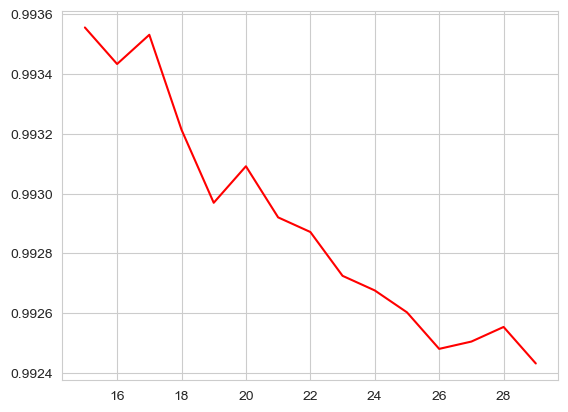

In [33]:
score_lt = []

for i in range(15, 30):
    rfc = RandomForestClassifier(min_samples_split = i, max_depth = 70, n_estimators = 77, random_state=90)
    score = cross_val_score(rfc, X, y, cv=10).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('Highest Score：{}'.format(score_max),
      'The number of subtrees：{}'.format(score_lt.index(score_max)+15))

x = np.arange(15, 30)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

Highest Score：0.992529529276376 The number of subtrees：30


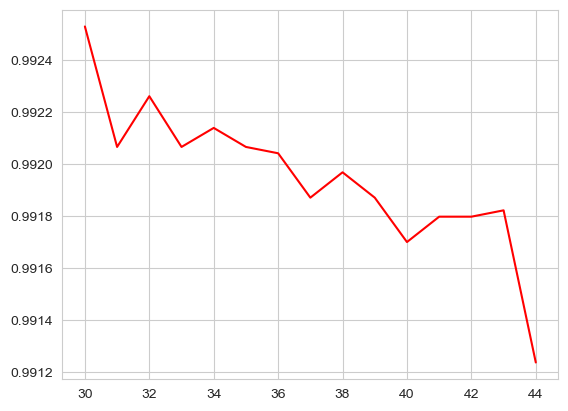

In [37]:
score_lt = []

for i in range(30, 45):
    rfc = RandomForestClassifier(min_samples_split = i, max_depth = 70, n_estimators = 77, random_state=90)
    score = cross_val_score(rfc, X, y, cv=10).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('Highest Score：{}'.format(score_max),
      'The number of subtrees：{}'.format(score_lt.index(score_max)+30))

x = np.arange(30, 45)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

Highest Score：0.9943117141258085 The number of subtrees：1


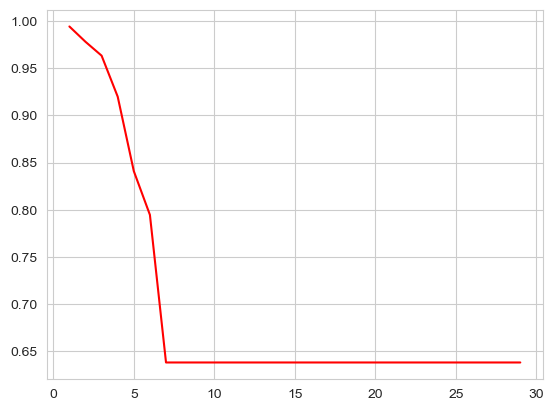

In [34]:
score_lt = []

for i in range(1, 30):
    rfc = RandomForestClassifier(min_samples_leaf = i, min_samples_split = 5, max_depth = 70, n_estimators = 77, random_state=90)
    score = cross_val_score(rfc, X, y, cv=10).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('Highest Score：{}'.format(score_max),
      'The number of subtrees：{}'.format(score_lt.index(score_max)+1))

x = np.arange(1, 30)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

In [38]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators':np.arange(76, 78),
    'max_depth':np.arange(69, 71),
    'min_samples_leaf':np.arange(1, 3),
    'min_samples_split':np.arange(4, 6)}

rfc = RandomForestClassifier(random_state=90)
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(X,y)
print(GS.best_params_)
print(GS.best_score_)

{'max_depth': 70, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 76}
0.9943605422508085


# 5.2.2.Model Training

In [22]:
rfc = RandomForestClassifier(n_estimators = 76, min_samples_leaf = 1, min_samples_split = 5, max_depth = 70, random_state = 90)
rfc.fit(Xtrain,ytrain)
prediction = rfc.predict(Xtest)
print('Decision Accuracy Score:',round(accuracy_score(ytest,prediction)*100),'%')

Decision Accuracy Score: 99 %


# 5.2.3.Result

In [23]:
import pydotplus

In [28]:
i=0
for per_rf in rfc.estimators_:
    dot_data = tree.export_graphviz(per_rf, out_file=None, 
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data)  
    i = i+1
    graph.write_pdf(str(i)+"DTtree.pdf") 


(process:1436): GLib-GIO-WARNING **: 17:45:40.297: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.5.15.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs

